# Edoardo Antonaci 1234431

# Homework1 : regression task

## Dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from skorch.callbacks import EarlyStopping
from skorch import NeuralNetRegressor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/homework1_regression/train_data.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/homework1_regression/test_data.csv')

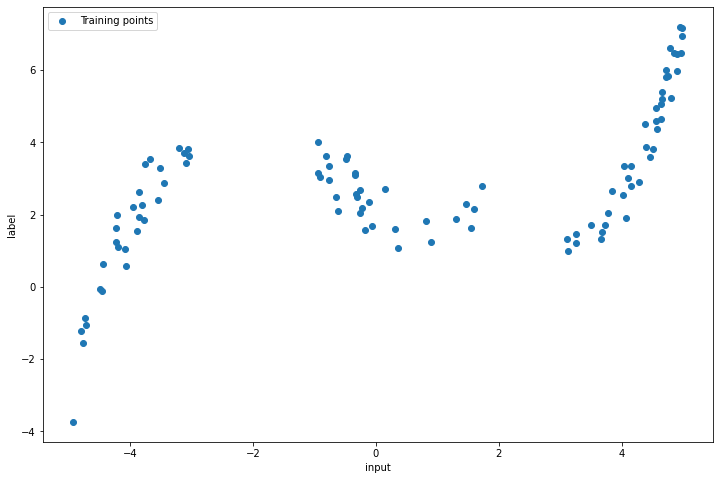

In [5]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

In [6]:
#train_dataset

X_train_dataset=train_df.input.values
Y_train_dataset=train_df.label.values

X_train_dataset=np.expand_dims(X_train_dataset, axis=1)
Y_train_dataset=np.expand_dims(Y_train_dataset, axis=1)

#test_dataset

X_test_dataset=test_df.input.values
Y_test_dataset=test_df.label.values

X_test_dataset=np.expand_dims(X_test_dataset, axis=1)
Y_test_dataset=np.expand_dims(Y_test_dataset, axis=1)

#to tensor

X_train_dataset=torch.from_numpy(X_train_dataset).float()
Y_train_dataset=torch.from_numpy(Y_train_dataset).float()

X_test_dataset=torch.from_numpy(X_test_dataset).float()
Y_test_dataset=torch.from_numpy(Y_test_dataset).float()


## Forward Neural Network implementation

In [7]:
class Reg(nn.Module):
    
    def __init__(self, Ni, Nh1,Nh2,Nh3,No,init_weight=None):
     
        
        super().__init__()

        torch.manual_seed(42)
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=No)
        
        
        self.act1 = nn.Sigmoid()
        self.act2 =nn.ReLU()
          
        if init_weight=="S" :
          torch.nn.init.sparse_(self.fc1.weight, sparsity=0.2, std=0.01)
          torch.nn.init.sparse_(self.fc2.weight, sparsity=0.2, std=0.01)
          torch.nn.init.sparse_(self.fc3.weight, sparsity=0.2, std=0.01)
        
        if init_weight=="N":
          torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0)
          self.fc1.bias.data.fill_(0.0)
          torch.nn.init.normal_(self.fc2.weight, mean=0.0, std=1.0)
          self.fc2.bias.data.fill_(0.0)
          torch.nn.init.normal_(self.fc3.weight, mean=0.0, std=1.0)
          self.fc3.bias.data.fill_(0.0)
        


    def forward(self, x):
        x = self.act2(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act2(self.fc3(x))
        x = self.out(x)
        
        return x

In [8]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [9]:
loss_function=nn.MSELoss()

my_early = EarlyStopping(
    monitor='valid_loss',
    patience=2000,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True)



net = NeuralNetRegressor(
    module=Reg,
    module__Ni= 1,
    module__Nh1 = 100,
    module__Nh2 = 120,
    module__Nh3 = 100,
    module__No = 1,
    max_epochs=10000,
    
    device=device,  
    optimizer = optim.Adam,
    optimizer__lr=0.0001,
    optimizer__eps=1e-08,
    optimizer__betas=(0.9, 0.999),
    optimizer__weight_decay=0, #L2 norm
    optimizer__amsgrad=False,
    criterion=nn.MSELoss,  #default
    callbacks = [my_early],
    verbose=0
)

In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    'module__Nh1': [100],
    'module__Nh2': [120],
    'module__Nh3': [100],
    'max_epochs': [5000,7000,10000],
    'optimizer__lr':[0.001,0.0001],
    'optimizer__weight_decay':[1e-4,0] #L2 norm,
}

gs = GridSearchCV(net, params, refit=True, cv=3, scoring="neg_mean_squared_error",verbose=10)
##https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


gs.fit(X_train_dataset,Y_train_dataset)

print(gs.best_score_, gs.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0.0001 
Network initialized


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Network initialized
[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0.0001, score=-1842.809, total=  31.0s
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0.0001 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.6s remaining:    0.0s


[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0.0001, score=-0.592, total= 1.1min
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0.0001 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0.0001, score=-3.032, total= 3.2min
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min remaining:    0.0s


[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0, score=-2203.161, total=  30.7s
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.5min remaining:    0.0s


[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0, score=-0.565, total= 1.1min
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min remaining:    0.0s


[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0, score=-7.535, total= 2.0min
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0.0001 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.6min remaining:    0.0s


[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0.0001, score=-1200.232, total=  48.6s
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0.0001 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.4min remaining:    0.0s


[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0.0001, score=-0.870, total= 3.3min
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0.0001 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 12.7min remaining:    0.0s


[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0.0001, score=-6.147, total= 3.3min
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 16.1min remaining:    0.0s


[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0, score=-1074.783, total=  48.5s
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0 
Network initialized
Network initialized
[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0, score=-0.871, total= 3.3min
[CV] max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0 
Network initialized
Network initialized
[CV]  max_epochs=5000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.0001, optimizer__weight_decay=0, score=-6.287, total= 3.3min
[CV] max_epochs=7000, module__Nh1=100, module__Nh2=120, module__Nh3=100, optimizer__lr=0.001, optimizer__weight_decay=0.0001 
Network initialized
Network initialized
[CV]  max_epochs=7000, module__Nh1=100, module__Nh2=12

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 123.7min finished


-360.6472358306249 {'max_epochs': 5000, 'module__Nh1': 100, 'module__Nh2': 120, 'module__Nh3': 100, 'optimizer__lr': 0.0001, 'optimizer__weight_decay': 0}


In [11]:
net=gs.best_estimator_

In [12]:
net.fit(X_train_dataset, Y_train_dataset)

Network initialized


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Reg(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=120, bias=True)
    (fc3): Linear(in_features=120, out_features=100, bias=True)
    (out): Linear(in_features=100, out_features=1, bias=True)
    (act1): Sigmoid()
    (act2): ReLU()
  ),
)

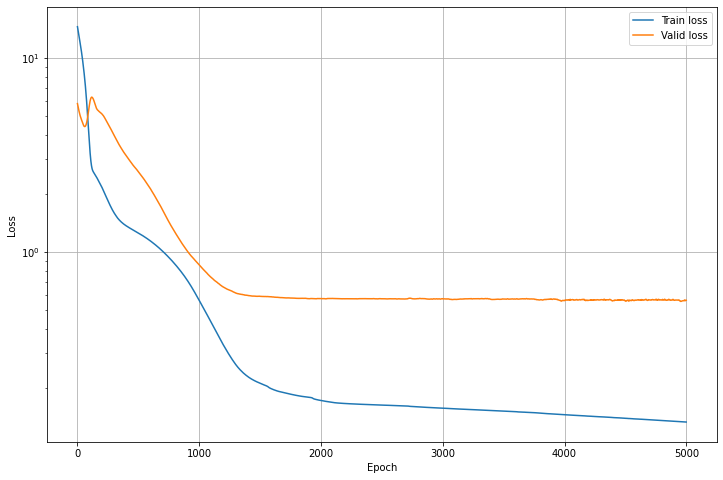

In [13]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(net.history[:, 'train_loss'], label='Train loss')
plt.semilogy(net.history[:, 'valid_loss'], label='Valid loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig("best_loss_graphs", dpi=400)
plt.show()


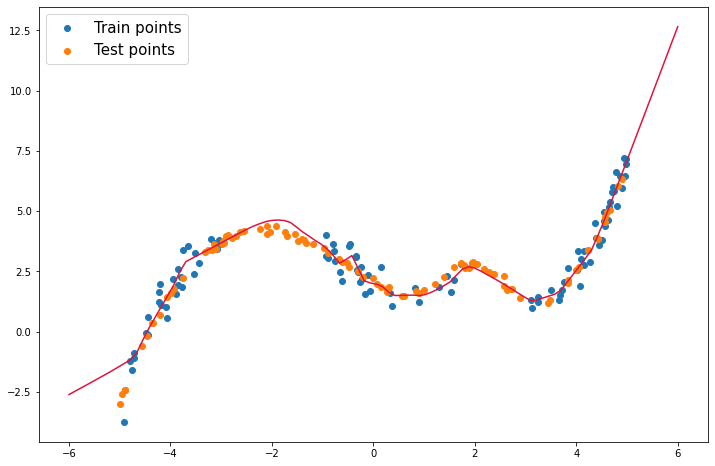

In [14]:
x=torch.tensor(np.linspace(-6,+6,100)).float().reshape(100,1)

#function approximeted
f=net.predict(x)

x=x.detach().cpu().numpy()

plt.figure(figsize=(12,8))
plt.plot(x,f,color="crimson")
plt.scatter(train_df[:]['input'],train_df[:]['label'],label="Train points")
plt.scatter(test_df[:]['input'],test_df[:]['label'],label="Test points")
plt.legend(loc='upper left', fontsize=15)
plt.savefig("best_function_predicted", dpi=400)
plt.show()


In [15]:
#SINTESI

#Train Loss
train_loss=net.history[:, 'train_loss'][-1]

#Val loss
val_loss=net.history[:, 'valid_loss'][-1]

#Test loss
y_pred = net.predict(X_test_dataset)
y_pred = torch.from_numpy(y_pred).float()
test_loss = loss_function(y_pred,Y_test_dataset)

print("Train Loss:\t",round(train_loss,3))
print("Val Loss:\t",round(val_loss,3))
print("Test Loss:\t",round(float(test_loss),3))

Train Loss:	 0.133
Val Loss:	 0.563
Test Loss:	 0.123


## Network analysis

In [16]:
#Access network parameters
my_best_net = net.module_

#First hidden Layer
h1_w = my_best_net.fc1.weight.data.cpu().numpy()
h1_b = my_best_net.fc1.bias.data.cpu().numpy()

#Second hidden Layer
h2_w = my_best_net.fc2.weight.data.cpu().numpy()
h2_b = my_best_net.fc2.bias.data.cpu().numpy()

#Third hidden Layer
h3_w = my_best_net.fc3.weight.data.cpu().numpy()
h3_b = my_best_net.fc3.bias.data.cpu().numpy()

# Output layer
out_w = my_best_net.out.weight.data.cpu().numpy()
out_b = my_best_net.out.bias.data.cpu().numpy()

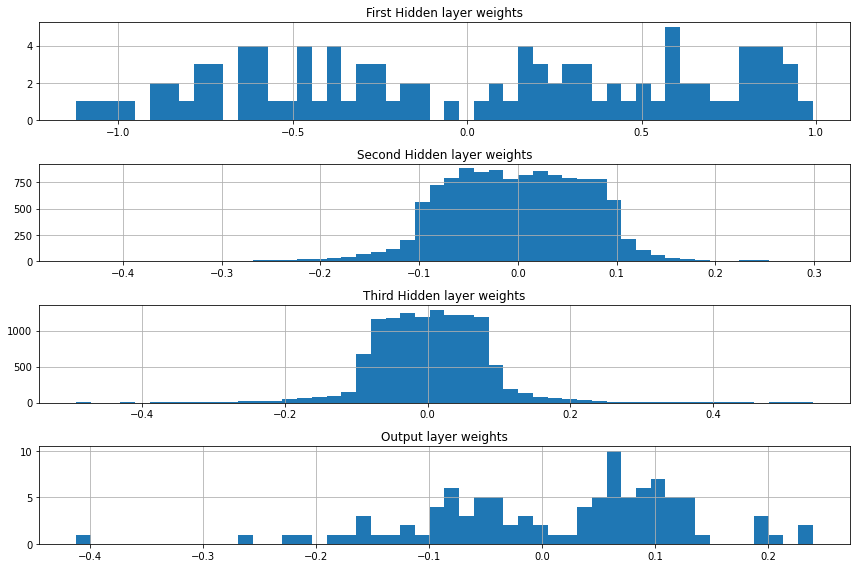

In [17]:
# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First Hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second Hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Third Hidden layer weights')
axs[3].hist(out_w.flatten(), 50)
axs[3].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.savefig("_Weights-histogram", dpi=400)
plt.show()

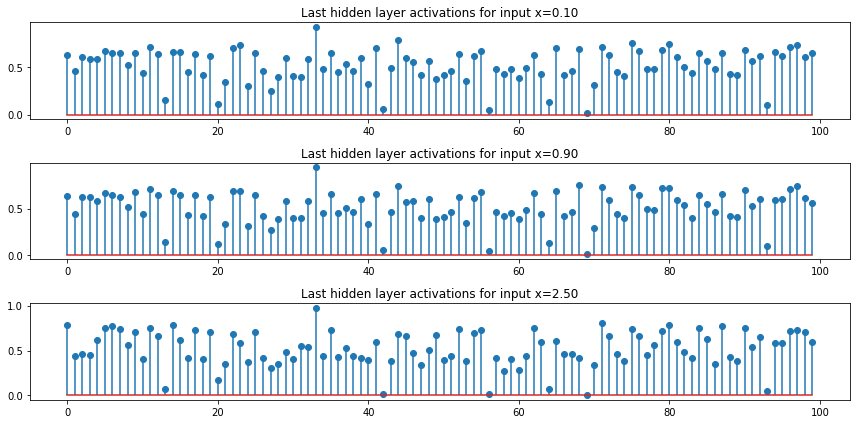

In [18]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)
    
### Register hook
net=my_best_net
hook_handle = net.fc3.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last hidden layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last hidden layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last hidden layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.savefig("Activations", dpi=400)
plt.show()